In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# 1. Генерация данных
def generate_data(num_samples):
    rng = (0, 1)
    X = np.random.rand(num_samples, 2) * (rng[1] - rng[0]) + rng[0]
    y = X[:, 0] * X[:, 1] + np.random.randn(num_samples) / 10
    return X, y
X, y = generate_data(int(1e6))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800000, 2), (200000, 2), (800000,), (200000,))

In [3]:
# 2. Определяем слои Гауссовых ФП
class GaussianMF(nn.Module):
    def __init__(self, mu, sigma):
        super().__init__()
        # Обучаемые параметры
        self.mu = nn.Parameter(torch.tensor(mu, dtype=torch.float32))
        self.sigma = nn.Parameter(torch.tensor(sigma, dtype=torch.float32))

    def forward(self, x):
    # x: (batch,1)
        return torch.exp(-((x - self.mu)**2) / (2 * self.sigma**2 + 1e-6))

In [4]:
# 3. Реализация ANFIS‑модели
class ANFIS(nn.Module):
    def __init__(self, n_inputs, n_mfs):
        """
        n_inputs: число входов (2)
        n_mfs: список длины n_inputs
        """
        super().__init__()
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        # 3.1. Создаём по n_mfs[i] Гауссовых ФП для каждого входа
        self.mfs = nn.ModuleList()
        for i in range(n_inputs):
            mfs_for_input = nn.ModuleList([
                GaussianMF(torch.rand(1).item(), torch.rand(1).item())
                for _ in range(n_mfs[i])
            ])
            self.mfs.append(mfs_for_input)
        # 3.2. Параметры для каждого правила: p_i, q_i, r_i
        # число правил = prod(n_mfs)
        from itertools import product
        self.rule_indices = list(product(*[range(m) for m in n_mfs]))
        n_rules = len(self.rule_indices)
        self.p = nn.Parameter(torch.randn(n_rules))
        self.q = nn.Parameter(torch.randn(n_rules))
        self.r = nn.Parameter(torch.randn(n_rules))
    def forward(self, x):
        """
        x: tensor (batch, n_inputs)
        возвращает y: tensor (batch,)
        """
        batch_size = x.shape[0]
        # 1) Степени принадлежности: для каждого входа i получаем (batch, n_mfs[i])
        mu_list = []
        for i in range(self.n_inputs):
            xi = x[:, i].unsqueeze(1)
            # конкатенируем все ФП по второму измерению
            mus = torch.cat([mf(xi) for mf in self.mfs[i]], dim=1)
            mu_list.append(mus)
        # 2) Вычисляем вес каждого правила

        W = []
        for idx in self.rule_indices:
            w = mu_list[0][:, idx[0]]
            for i in range(1, self.n_inputs):
                w = w * mu_list[i][:, idx[i]]
            W.append(w.unsqueeze(1))
        W = torch.cat(W, dim=1)
        # 3) Нормализация
        W_sum = W.sum(dim=1, keepdim=True) + 1e-6
        W_norm = W / W_sum
        # 4) Линейные выходы каждого правила: f_i = p_i*x1 + q_i*x2 + r_i
        # p, q, r: (n_rules,)
        f_list = []
        for i, (p, q, r) in enumerate(zip(self.p, self.q, self.r)):
            f = p * x[:, 0] + q * x[:, 1] + r  # (batch,)
            f_list.append(f.unsqueeze(1))
        f = torch.cat(f_list, dim=1)  # (batch, n_rules)
        # 5) Итоговый выход
        y = (W_norm * f).sum(dim=1)
        return y

In [5]:
# 4. Инициализация модели, оптимизатор и критерий
model = ANFIS(n_inputs=2, n_mfs=[2,2]).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-1)
criterion = nn.MSELoss()

In [6]:
def mse(outputs, yb):
    return ((outputs - yb) ** 2).mean()

In [7]:
X_train_t, X_test_t, y_train_t, y_test_t = (
    torch.from_numpy(X_train).to(device),
    torch.from_numpy(X_test).to(device),
    torch.from_numpy(y_train).to(device),
    torch.from_numpy(y_test).to(device)
)

In [ ]:
train_losses = list()
test_losses = list()

# 5. Обучение
for epoch in range(1, 150 + 1):
    print(f'{epoch = }')
    model.train()
    optimizer.zero_grad()
    preds = model(X_train_t)
    loss = mse(preds, y_train_t)
    loss.backward()
    optimizer.step() 
    print(f'train loss: {loss.item()}')
    train_losses.append(loss.item())
    model.eval()
    with torch.no_grad():
        preds = model(X_test_t)
    loss = mse(preds, y_test_t)
    print(f'test loss: {loss.item()}')
    test_losses.append(loss.item())

epoch = 1
train loss: 1.388508809785714
test loss: 1.4428009192483087
epoch = 2
train loss: 1.4387989760239375
test loss: 0.21588412555568806
epoch = 3
train loss: 0.2146796912199101
test loss: 0.14471287560303311
epoch = 4
train loss: 0.1445729063717791
test loss: 0.26427125952669145
epoch = 5
train loss: 0.26419353455333106
test loss: 0.2903938228407153
epoch = 6
train loss: 0.29035956245274797
test loss: 0.2455108048760443
epoch = 7
train loss: 0.24546666285344118
test loss: 0.17165609423525982
epoch = 8
train loss: 0.1715499454835377
test loss: 0.1036874639391007
epoch = 9
train loss: 0.1034862678032764
test loss: 0.06387468174005823
epoch = 10
train loss: 0.06356648429306658
test loss: 0.05872292719915568
epoch = 11
train loss: 0.0583145052385596
test loss: 0.07869367442879534
epoch = 12
train loss: 0.07820667789332324
test loss: 0.10437753971330262
epoch = 13
train loss: 0.10384293045884803
test loss: 0.11809163155451251
epoch = 14
train loss: 0.11754306023482815
test loss: 0.112

In [9]:
# 6. Оценка на тесте
mse_test = test_losses[-1]
rmse_test = test_losses[-1]**0.5
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}")

Test MSE: 0.01334, RMSE: 0.11552


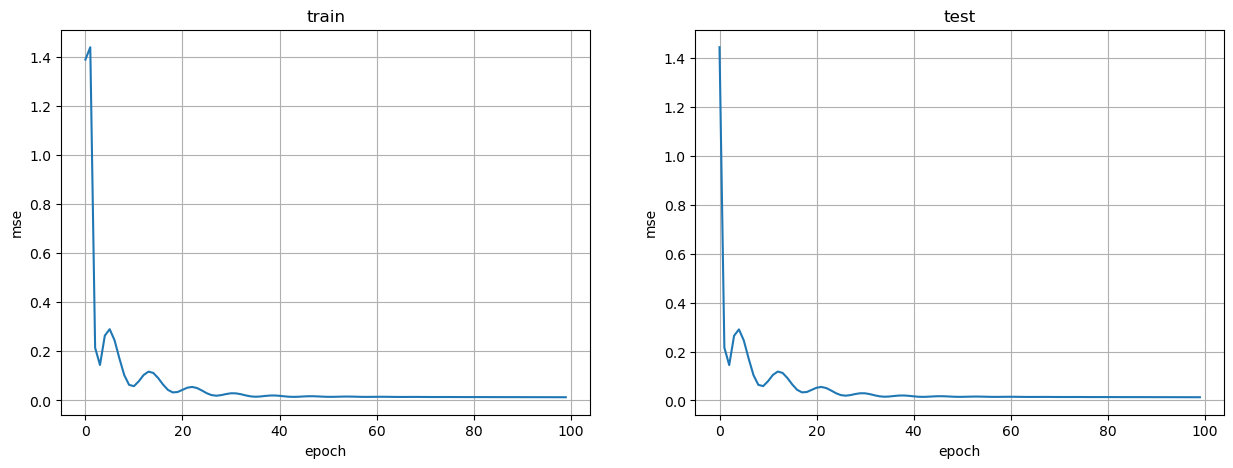

In [10]:
# 7. Визуализация результатов
# 7.1. Кривая обучения
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(train_losses)
axs[0].set_title('train')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('mse')
axs[0].grid()

axs[1].plot(test_losses)
axs[1].set_title('test')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('mse')
axs[1].grid()

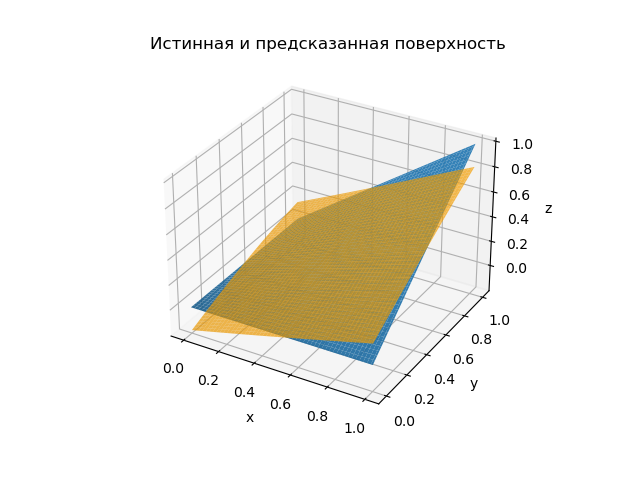

In [13]:
%matplotlib widget
# 7.2. Истинные vs предсказанные

# 1. Сетка
X, Y = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))

# 2. Истинные значения
Z = X * Y  # или любая другая реальная зависимость

# 3. Подготовка к предсказанию
XY = np.stack([X.ravel(), Y.ravel()], axis=1)  # (10000, 2)
XY_tensor = torch.from_numpy(XY).to(device).float()       # (10000, 2), dtype float32

# 4. Предсказания
with torch.no_grad():
    Z_predicted = model(XY_tensor).cpu().numpy().reshape(100, 100)

# 5. Построение 3D-графика
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot_surface(X, Y, Z, alpha=0.9, label='True')
ax.plot_surface(X, Y, Z_predicted, color='orange', alpha=0.7, label='Predicted')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title("Истинная и предсказанная поверхность")
plt.show()

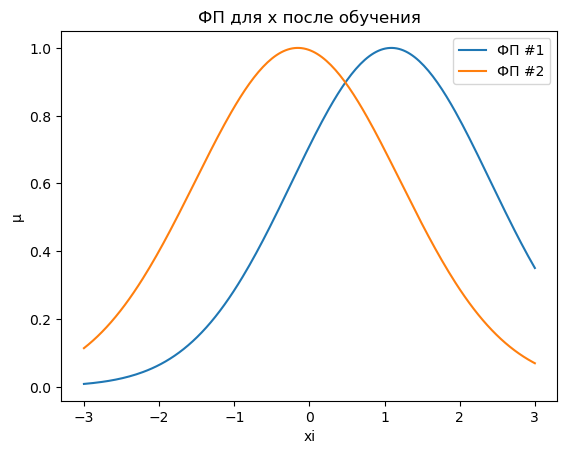

In [17]:
%matplotlib inline
# 7.3. Функции принадлежности до и после обучения (для первого входа)
x_grid = torch.linspace(-3,3,200).unsqueeze(1).to(device)
plt.figure()
for idx, mf in enumerate(model.mfs[0]):
    # Вычисляем значения ФП после обучения и отсоединяем от графа
    y_after = mf(x_grid).detach().cpu().numpy().flatten()
    # Метка по индексу ФП
    plt.plot(x_grid.cpu().numpy(), y_after, label=f"ФП #{idx+1}")
plt.xlabel('xi')
plt.ylabel('μ')
plt.title('ФП для x после обучения')
plt.legend()